In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; height:100% !important; }</style>"))

In [12]:
from IPython.display import HTML

display(HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>'''))

In [16]:

# READ ME! This first box is where your Start and End location are selected, 
# Also slect the type of bike router you would prefer (ballanced,Bike Facility pref, bike trail pref, path with cars)
# THIS ROUTER WORKS FOR ONLY THE CITY OF SEATTLE

from ipyleaflet import Map, Marker, Icon, AwesomeIcon
import ipywidgets as widgets
from IPython.display import display
import re

# Creates a map centered at a specific location, added section to increase hight as well
m = Map(center=(47.6062, -122.3321), zoom=11, layout={'height': '800px'})

# Creates an AwesomeIcon with a custom color (e.g., red)
startIcon = AwesomeIcon(name='check', marker_color='green')
endIcon = AwesomeIcon(name='check', marker_color='red')

# Create a marker at a specific location
start = Marker(location=(47.5913,-122.2945), icon=startIcon)
end = Marker(location=(47.6153, -122.3000), icon=endIcon)

# Variables to store the marker's coordinates
start_lat = start.location[0]
start_lon = start.location[1]
end_lat = end.location[0]
end_lon = end.location[1]

# Callback function to update the variables when the marker's position changes
def on_marker_move(change):
    global start_lat, start_lon
    start_lat, start_lon = change['new']
def on_marker_move(change):
    global end_lat, end_lon
    end_lat, end_lon = change['new']

# Set up the callback
start.observe(on_marker_move, names=['location'])
end.observe(on_marker_move, names=['location'])

#--------------------- attempting to add buttons
# Variable to hold the assigned value this is analog number
an = 1

# Extracts string (Int extractor)
def IE(input_string):
    current_number = ''
    for char in input_string:
        if char.isdigit():
            current_number += char
        elif current_number:
            return int(current_number)
    return None

# Function to update the the radio number when a button is clicked
def on_button_click(button):
    global an
#     updates analong number 
    an = int(IE(button.description))
#     updates a button that displays the Anolog number 
    button_5.description = str(an)


# Create clickable buttons
button_1 = widgets.Button(description='1 ballanced router')
button_2 = widgets.Button(description='2 prefer bike facilities')
button_3 = widgets.Button(description='3 prefer bike trails')
button_4 = widgets.Button(description='4 Path with Cars')
button_5 = widgets.Button(description=str(an))

# Link event handler function to each button so the number is changed
button_1.on_click(lambda _: on_button_click(button_1))
button_2.on_click(lambda _: on_button_click(button_2))
button_3.on_click(lambda _: on_button_click(button_3))
button_4.on_click(lambda _: on_button_click(button_4))


# Display the map and marker
m.add_layer(start)
m.add_layer(end)
# Enable scroll wheel zoom
m.scroll_wheel_zoom = True
display(button_1, button_2, button_3, button_4, button_5)
display(m)



Button(description='1 ballanced router', style=ButtonStyle())

Button(description='2 prefer bike facilities', style=ButtonStyle())

Button(description='3 prefer bike trails', style=ButtonStyle())

Button(description='4 Path with Cars', style=ButtonStyle())

Button(description='1', style=ButtonStyle())

Map(center=[47.6062, -122.3321], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

Button(description='Convert to KML', style=ButtonStyle())

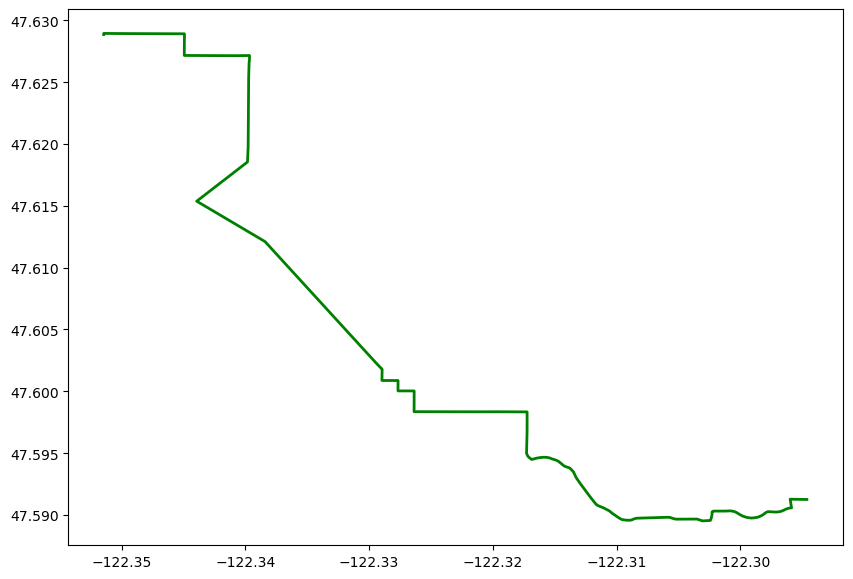

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import folium
import ipywidgets as widgets
from IPython.display import display
import simplekml
from qgis.core import *
from qgis.gui import *
from qgis.analysis import *

from qgis.PyQt.QtCore import *
from qgis.PyQt.QtGui import *

# Setting up start and end points from ipyleaflet 
startPoint = QgsPointXY(start.location[1],start.location[0])
endPoint = QgsPointXY(end.location[1],end.location[0])
network = ('networkshps/SeattleNetwork28.shp')

if an == 4:
    #setting up default router (only need one vector Layer, director StartPoint and EndPoint)
    vectorLayer = QgsVectorLayer(network)
    director = QgsVectorLayerDirector(vectorLayer, -1, '', '', '', QgsVectorLayerDirector.DirectionBoth)
    strategy = QgsNetworkDistanceStrategy()
    director.addStrategy(strategy)

    builder = QgsGraphBuilder(vectorLayer.sourceCrs())

    tiedPoints = director.makeGraph(builder, [startPoint, endPoint])
    tStart, tStop = tiedPoints

    graph = builder.graph()
    idxStart = graph.findVertex(tStart)
    idxEnd = graph.findVertex(tStop)

    (tree, costs) = QgsGraphAnalyzer.dijkstra(graph, idxStart, 0)


    if tree[idxEnd] == -1:
        raise Exception('No route!')

    # Total cost
    cost = costs[idxEnd]

    # Add last point
    route = [graph.vertex(idxEnd).point()]

    # Iterate the graph
    while idxEnd != idxStart:
        idxEnd = graph.edge(tree[idxEnd]).fromVertex()
        route.insert(0, graph.vertex(idxEnd).point())

    # Check if the route has at least two points
    if len(route) < 2:
        raise ValueError('Route has less than two points')

    # Convert the route to a GeoPandas DataFrame
    route_coords = [(point.x(), point.y()) for point in route]
    route_line = LineString(route_coords)
    route_gdf = gpd.GeoDataFrame(geometry=[route_line])


#---------------------------------------- Weighted Ballanced Router (Speed8 ballanced)

if an == 1:
    #Setting up Router "Speed" 8 here: (this can go wrong)
    vectorLayer8 = QgsVectorLayer(network)
    director8 = QgsVectorLayerDirector(vectorLayer8, -1, '', '', '', QgsVectorLayerDirector.DirectionBoth)
    speed_field_name8 = 'RoutingSp8'
    # Get the index of the speed field
    speed_field_index8 = vectorLayer8.fields().indexFromName(speed_field_name8)
    # Set the speed units and conversion factor
    speed_units8 = QgsUnitTypes.DistanceKilometers  # Adjust the units as needed
    speed_conversion8 = 1.0  # Adjust the conversion factor as needed
    strategy8 = QgsNetworkSpeedStrategy(speed_field_index8, speed_units8, speed_conversion8)
    director8.addStrategy(strategy8)

    builder8 = QgsGraphBuilder(vectorLayer8.sourceCrs())

    #For Speed 8:
    tiedPoints8 = director8.makeGraph(builder8, [startPoint, endPoint])
    tStart8, tStop8 = tiedPoints8

    #for Speed8:
    graph8 = builder8.graph()
    idxStart8 = graph8.findVertex(tStart8)
    idxEnd8 = graph8.findVertex(tStop8)

    (tree8, costs8) = QgsGraphAnalyzer.dijkstra(graph8, idxStart8, 0)

    if tree8[idxEnd8] == -1:
        raise Exception('No route!')

    cost8 = costs8[idxEnd8]  

    # Add last point
    route8 = [graph8.vertex(idxEnd8).point()]

    # Iterate the graph
    while idxEnd8 != idxStart8:
        idxEnd8 = graph8.edge(tree8[idxEnd8]).fromVertex()
        route8.insert(0, graph8.vertex(idxEnd8).point())

    # Check if the route has at least two points
    if len(route8) < 2:
        raise ValueError('Route has less than two points')

    # Conversion for Speed 8:
    route_coords8 = [(point.x(), point.y()) for point in route8]
    route_line8 = LineString(route_coords8)
    route_gdf8 = gpd.GeoDataFrame(geometry=[route_line8])
    
    # INSERT SECOND BALLANCED ROUTER HERE ROUTE5 

#---------------------------------------- Weighted Bike Facility Router (Speed6 facilities pref)

if an == 2:
    #Setting up Router "Speed" 6 here: (this can go wrong)
    vectorLayer6 = QgsVectorLayer(network)
    director6 = QgsVectorLayerDirector(vectorLayer6, -1, '', '', '', QgsVectorLayerDirector.DirectionBoth)
    speed_field_name6 = 'RoutingSp6'
    # Get the index of the speed field
    speed_field_index6 = vectorLayer6.fields().indexFromName(speed_field_name6)
    # Set the speed units and conversion factor
    speed_units6 = QgsUnitTypes.DistanceKilometers  # Adjust the units as needed
    speed_conversion6 = 1.0  # Adjust the conversion factor as needed
    strategy6 = QgsNetworkSpeedStrategy(speed_field_index6, speed_units6, speed_conversion6)
    director6.addStrategy(strategy6)

    builder6 = QgsGraphBuilder(vectorLayer6.sourceCrs())

    #For Speed 6:
    tiedPoints6 = director6.makeGraph(builder6, [startPoint, endPoint])
    tStart6, tStop6 = tiedPoints6

    #for Speed6:
    graph6 = builder6.graph()
    idxStart6 = graph6.findVertex(tStart6)
    idxEnd6 = graph6.findVertex(tStop6)

    (tree6, costs6) = QgsGraphAnalyzer.dijkstra(graph6, idxStart6, 0)

    if tree6[idxEnd6] == -1:
        raise Exception('No route!')

    cost6 = costs6[idxEnd6]  

    # Add last point
    route6 = [graph6.vertex(idxEnd6).point()]

    # Iterate the graph
    while idxEnd6 != idxStart6:
        idxEnd6 = graph6.edge(tree6[idxEnd6]).fromVertex()
        route6.insert(0, graph6.vertex(idxEnd6).point())

    # Check if the route has at least two points
    if len(route6) < 2:
        raise ValueError('Route has less than two points')

    # Conversion for Speed 6:
    route_coords6 = [(point.x(), point.y()) for point in route6]
    route_line6 = LineString(route_coords6)
    route_gdf6 = gpd.GeoDataFrame(geometry=[route_line6])

#---------------------------------------- Weighted Trail Router (Speed7 trails pref)

if an == 3:
    #Setting up Router "Speed" 7 here: (this can go wrong)
    vectorLayer7 = QgsVectorLayer(network)
    director7 = QgsVectorLayerDirector(vectorLayer7, -1, '', '', '', QgsVectorLayerDirector.DirectionBoth)
    speed_field_name7 = 'RoutingSp7'
    # Get the index of the speed field
    speed_field_index7 = vectorLayer7.fields().indexFromName(speed_field_name8)
    # Set the speed units and conversion factor
    speed_units7 = QgsUnitTypes.DistanceKilometers  # Adjust the units as needed
    speed_conversion7 = 1.0  # Adjust the conversion factor as needed
    strategy7 = QgsNetworkSpeedStrategy(speed_field_index7, speed_units7, speed_conversion7)
    director7.addStrategy(strategy7)

    builder7 = QgsGraphBuilder(vectorLayer7.sourceCrs())

    #For Speed 7:
    tiedPoints7 = director7.makeGraph(builder7, [startPoint, endPoint])
    tStart7, tStop7 = tiedPoints7

    #for Speed7:
    graph7 = builder7.graph()
    idxStart7 = graph7.findVertex(tStart7)
    idxEnd7 = graph7.findVertex(tStop7)

    (tree7, costs7) = QgsGraphAnalyzer.dijkstra(graph7, idxStart7, 0)

    if tree7[idxEnd7] == -1:
        raise Exception('No route!')

    cost7 = costs7[idxEnd7]  

    # Add last point
    route7 = [graph7.vertex(idxEnd7).point()]

    # Iterate the graph
    while idxEnd7 != idxStart7:
        idxEnd7 = graph7.edge(tree7[idxEnd7]).fromVertex()
        route7.insert(0, graph7.vertex(idxEnd7).point())

    # Check if the route has at least two points
    if len(route7) < 2:
        raise ValueError('Route has less than two points')

    # Conversion for Speed 7:
    route_coords7 = [(point.x(), point.y()) for point in route7]
    route_line7 = LineString(route_coords7)
    route_gdf7 = gpd.GeoDataFrame(geometry=[route_line7])


#--------------------------- rest of conversion for viewing here

# Create the plot of the GeoDataFrame and basemap
fig, ax = plt.subplots(figsize=(10, 10))
if an == 4:
    #Add if for SpeedDefault----------
    # Plot route_gdf on top
    route_gdf.plot(ax=ax, color='red', linewidth=2)

    # Read the GeoDataFrames for Speed 
    route_gdf = gpd.GeoDataFrame.from_features(route_gdf, crs='EPSG:4326')

    # Convert GeoDataFrame for Speed8 to GeoJson
    route_geojson = route_gdf.to_crs('EPSG:4326').to_json()

if an == 1:
    #Add if for Speed8----------
    # Plot route_gdf8 on top
    route_gdf8.plot(ax=ax, color='green', linewidth=2)

    # Read the GeoDataFrames for Speed 8
    route_gdf8 = gpd.GeoDataFrame.from_features(route_gdf8, crs='EPSG:4326')

    # Convert GeoDataFrame for Speed8 to GeoJson
    route_geojson8 = route_gdf8.to_crs('EPSG:4326').to_json()

if an == 2:
    #Add if for Speed6------------
    # Plot route_gdf6 on top
    route_gdf6.plot(ax=ax, color='green', linewidth=2)

    # Read the GeoDataFrames for Speed 6
    route_gdf6 = gpd.GeoDataFrame.from_features(route_gdf6, crs='EPSG:4326')

    # Convert GeoDataFrame for Speed6 to GeoJson
    route_geojson6 = route_gdf6.to_crs('EPSG:4326').to_json()

if an == 3:
    #Add if for Speed7---------------
    # Plot route_gdf7 on top
    route_gdf7.plot(ax=ax, color='green', linewidth=2)

    # Read the GeoDataFrames for Speed 7
    route_gdf7 = gpd.GeoDataFrame.from_features(route_gdf7, crs='EPSG:4326')

    # Convert GeoDataFrame for Speed8 to GeoJson
    route_geojson7 = route_gdf7.to_crs('EPSG:4326').to_json()

# Create a Folium map centered on Seattle
m = folium.Map(location=[47.6062, -122.3321], zoom_start=12)

# Set up button that converts to KML
# def geojson_to_kml(geojson_path, kml_path):
#     try:
#         gdf = gpd.read_file(geojson_path)
#         gdf.to_file(kml_path, driver='KML')
#         print("Conversion successful. KML file saved.")
#     except Exception as e:
#         print("Error during conversion:", e)
def geojson_to_kml(geojson_path, kml_path):
    try:
        gdf = gpd.read_file(geojson_path)
        kml = simplekml.Kml()

        for idx, row in gdf.iterrows():
            coords = row['geometry'].coords[:]

            linestring = kml.newlinestring(name=str(idx), coords=coords)
            linestring.extrude = 1
            linestring.altitudemode = simplekml.AltitudeMode.clamptoground
            linestring.style.linestyle.width = 3
            linestring.style.linestyle.color = simplekml.Color.red  # Customize the line color here

        kml.save(kml_path)
        print("Conversion successful. KML file saved.")
    except Exception as e:
        print("Error during conversion:", e)


if an == 4:
    #Add if for SpeedDefault-------------
    # Add Speed Default route GeoJSON to folium map
    folium.GeoJson(route_geojson, style_function=lambda x: {'color': 'red', 'weight': 2, 'opacity':0.6}).add_to(m)
    def on_button_click(b):
        geojson_path = route_geojson  # Replace this with the actual path to your GeoJSON file
        kml_path = 'DefaultRoute_kml.kml'  # Replace this with the desired path for the output KML file
        geojson_to_kml(geojson_path, kml_path)

    
if an == 1:
    #Add if for Speed8-------------
    # Add Speed 8 route GeoJSON to folium map
    folium.GeoJson(route_geojson8, style_function=lambda x: {'color': 'green', 'weight': 2}).add_to(m)
    def on_button_click(b):
        geojson_path = route_geojson8  # Replace this with the actual path to your GeoJSON file
        kml_path = 'BallancedRoute_kml.kml'  # Replace this with the desired path for the output KML file
        geojson_to_kml(geojson_path, kml_path)
    
if an == 2:
    #Add if for Speed6-------------
    # Add Speed 6 route GeoJSON to folium map
    folium.GeoJson(route_geojson6, style_function=lambda x: {'color': 'green', 'weight': 2}).add_to(m)
    def on_button_click(b):
        geojson_path = route_geojson6  # Replace this with the actual path to your GeoJSON file
        kml_path = 'FacilityRoute_kml.kml'  # Replace this with the desired path for the output KML file
        geojson_to_kml(geojson_path, kml_path)
    
if an == 3:
    #Add if for Speed7-------------
    # Add Speed 7 route GeoJSON to folium map
    folium.GeoJson(route_geojson7, style_function=lambda x: {'color': 'green', 'weight': 2}).add_to(m)
    def on_button_click(b):
        geojson_path = route_geojson7  # Replace this with the actual path to your GeoJSON file
        kml_path = 'TrailRoute_kml.kml'  # Replace this with the desired path for the output KML file
        geojson_to_kml(geojson_path, kml_path)
    

# Display the map
display(m)
button = widgets.Button(description="Convert to KML")
button.on_click(on_button_click)
display(button)